<a href="https://colab.research.google.com/github/Sourav1429/-Machine-Learning-for-Engineering-and-science-applications-NPTEL-course/blob/main/Pima_dataset_working_RBNNvsFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [5]:
def one_hot(y,n_output):
    y_ret = [];
    for i in y:
        val = np.zeros(n_output)
        val[i] = 1;
        y_ret.append(val);
    return np.array(y_ret)

In [15]:
def gen_weights(mu_mat,layer_wise_neurons,sigma):
    l = len(mu_mat)
    weights_by_layer = dict()
    for i in range(l):
        #print(type(i))
        #print(layer_wise_neurons)
        weights = np.zeros((layer_wise_neurons[i],layer_wise_neurons[i+1]))
        for j in range(layer_wise_neurons[i+1]):
            weights[:,j] = np.random.normal(mu_mat[i][j],sigma[i][j],layer_wise_neurons[i])
            weights[:,j] = weights[:,j]
        weights_by_layer[i] = weights
    return weights_by_layer

In [16]:
def activation(s,type_= 0):
    if(type_==1):
        return 1/(1+np.exp(-s))
    else:
        return np.where(s>=0,s,0)
def forward(weights_by_layers,x):
    l = len(weights_by_layers)
    a = x
    collected_weights = dict()
    for i in range(l):
        w = weights_by_layers[i]
        #print(w)
        #print("=======ok now========")
        #print(a)
        z = np.matmul(w.T,a)
        a = activation(z,1)
        #collected_weights[i] = a
    return a

In [17]:
def update(mu_mat,store,tot_err,chosen_index):
    val = np.sum(tot_err[chosen_index])
    mu_mat = (1-gamma)*mu_mat
    #print("chosen index:",chosen_index[0])
    #chosen_index = chosen_index[0]
    for i in range(len(chosen_index)):
        weights_dist = store[chosen_index[i]]
        err = tot_err[chosen_index[i]]
        #print("Error:",tot_err)
        for x in weights_dist:
            weights_dist[x] = weights_dist[x]*err/val
            mu_new = np.mean(weights_dist[x],axis=0)
            mu_mat[x] = mu_mat[x] + gamma*mu_new
    return mu_mat

In [21]:
class RBNN:
    def __init__(self,n_layers,mu_mat,nj_list,rho,alyer_wise_neurons,sigma):
        self.n_layers = n_layers
        self.mu_mat = mu_mat
        self.nj_list = nj_list
        self.rho = rho
        self.layer_wise_neurons = alyer_wise_neurons
        self.sigma_mat = sigma
        self.best_mu_mat = None
        self.best_acc = -1000000
    def activation(self,s):
        return np.where(s>=0,s,0)
    def error(self,y,y_hat):
      #return -np.matmul(y,np.log(y_hat))
      if(np.argmax(y)==np.argmax(y_hat)):
        return -np.matmul(y,np.log(y_hat))
      else:
        actual_class = np.argmax(y)
        y_hat[actual_class] = y_hat[actual_class]*0.02
        y_hat[1-actual_class] = y_hat[1-actual_class]*0.98
        return -np.matmul(y,np.log(y_hat))
    def CEO(self,nj):
        store=[];tot_err=[];acc_list = []
        for j in range(nj):
            weights_by_layer = gen_weights(self.mu_mat,self.layer_wise_neurons,self.sigma_mat)
            store.append(weights_by_layer)
            error = 0
            acc = 0;
            for (x,y) in zip(self.X,self.y_):
                y_hat = forward(weights_by_layer,x)
                #print("Predicted:",y_hat)
                error = error + np.sum(self.error(y,y_hat))
                #print("predicted:",y_hat,"actual:",y)
                #input()
                acc = acc+ (np.argmax(y_hat)==np.argmax(y))
                #print("Yhat,error,acc:",y_hat,error,acc)
                #input()
            acc = acc/len(self.y_)
            tot_err.append(error/len(self.y_))
            acc_list.append(acc)
        acc_list,tot_err = np.array(acc_list),np.array(tot_err)
        #print(np.sort(tot_err))
        #print(np.argsort(tot_err))
        chosen_index = np.argsort(tot_err)[0:int(self.rho*nj)]
        #print("first chosen index",chosen_index)
        self.mu_mat = update(self.mu_mat,store,tot_err,chosen_index)
        print("Mean matrix:",self.mu_mat)
        acc2 = np.mean(acc_list[chosen_index])
        if(acc2>self.best_acc):
          self.best_mu_mat = self.mu_mat
          self.best_acc = acc2
        return np.mean(tot_err[chosen_index]), acc2
    def train(self,X,y_):
        self.X = X
        self.y_ = y_
        err_plot,acc_plot=[],[]
        for nj in tqdm(nj_list):
            train_err,acc = self.CEO(nj)
            print("Train error {}".format(train_err))
            print("Train accuracy {}".format(acc))
            err_plot.append(train_err)
            acc_plot.append(acc)
        #print("Before returning:",self.mu_mat)
        return err_plot,acc_plot,self.best_mu_mat,self.sigma_mat
    def predict(self,X,y_):
        weights_by_layer = gen_weights(self.mu_mat,self.layer_wise_neurons,self.sigma_mat)
        #print("weights: by :",weights_by_layer)
        #print("input:",X)
        y_hat = forward(weights_by_layer,X)
        print("Actual output:{} and predicted ouput:{}".format(np.argmax(y_),np.argmax(y_hat)))

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
path = "/content/diabetes.csv"
data = pd.read_csv(path)
y = data['Outcome'].to_numpy()
X = data.drop(['Outcome'],axis=1).to_numpy()

max_val_col = np.max(X,axis=0)
print(np.where(X<0))
X_new = X/max_val_col
gamma = 0.9
nj_list = np.arange(100,600,20)
rho = 0.25
n_features = len(data.columns) - 1
n_output = len(data['Outcome'].unique())
print(n_output)
#scaler = StandardScaler()
#X_new = scaler.fit_transform(X)
#dataf = pd.DataFrame(X_new, columns=['Column_A', 'Column_B', 'Column_C'])
#dataf.to_excel('Polished_data.xlsx')
#X_new = X
y = one_hot(y,n_output)
layer_wise_neurons = [n_features,2,n_output]
mu_mat = []
sigma_mat = []
for i in range(len(layer_wise_neurons)-1):
    mu_mat.append(np.zeros(layer_wise_neurons[i+1]))
    sigma_mat.append(np.ones(layer_wise_neurons[i+1])*0.5)
print(mu_mat)
mu_mat = np.array(mu_mat)
sigma_mat = np.array(sigma_mat)
#print(mu_mat)
model2 = RBNN(len(layer_wise_neurons),mu_mat,nj_list,rho,layer_wise_neurons,sigma_mat)
err_plot,acc_plot,mu_mat,sigma_mat = model2.train(X_new,y)

(array([], dtype=int64), array([], dtype=int64))
2
[array([0., 0.]), array([0., 0.])]


  4%|▍         | 1/25 [00:03<01:35,  4.00s/it]

Mean matrix: [[ 0.02089846 -0.00798454]
 [ 0.34729744 -0.00621066]]
Train error 1.9431692255983044
Train accuracy 0.6521354166666667


  8%|▊         | 2/25 [00:07<01:28,  3.84s/it]

Mean matrix: [[ 0.1152037  -0.0549342 ]
 [ 0.62995003  0.1457724 ]]
Train error 1.8304037491548206
Train accuracy 0.6557291666666669


 12%|█▏        | 3/25 [00:11<01:26,  3.93s/it]

Mean matrix: [[ 0.17227544 -0.01729117]
 [ 0.91595143  0.28614637]]
Train error 1.7551882975680233
Train accuracy 0.6527901785714286


 16%|█▌        | 4/25 [00:17<01:37,  4.64s/it]

Mean matrix: [[0.2287611  0.04574722]
 [1.21661115 0.46876521]]
Train error 1.676271285226715
Train accuracy 0.6510416666666666


 20%|██        | 5/25 [00:22<01:36,  4.84s/it]

Mean matrix: [[0.31468309 0.14813007]
 [1.5263581  0.68297258]]
Train error 1.5959936841929485
Train accuracy 0.6513310185185186


 24%|██▍       | 6/25 [00:29<01:45,  5.53s/it]

Mean matrix: [[0.36695463 0.25444462]
 [1.70759249 0.97310843]]
Train error 1.5308992594531652
Train accuracy 0.65203125


 28%|██▊       | 7/25 [00:35<01:44,  5.83s/it]

Mean matrix: [[0.45261234 0.32221672]
 [1.9565783  1.22774642]]
Train error 1.484045795319517
Train accuracy 0.6511126893939391


 32%|███▏      | 8/25 [00:45<01:56,  6.87s/it]

Mean matrix: [[0.60630501 0.43698377]
 [2.19019418 1.40453107]]
Train error 1.441662976909114
Train accuracy 0.6525173611111109


 36%|███▌      | 9/25 [00:53<01:56,  7.30s/it]

Mean matrix: [[0.73217339 0.54468087]
 [2.35563129 1.61327127]]
Train error 1.4237937137580916
Train accuracy 0.6510817307692307


 40%|████      | 10/25 [01:01<01:54,  7.64s/it]

Mean matrix: [[0.85021789 0.66637893]
 [2.55544578 1.87019966]]
Train error 1.4019102005443742
Train accuracy 0.6511532738095236


 44%|████▍     | 11/25 [01:11<01:56,  8.29s/it]

Mean matrix: [[0.95995252 0.79614272]
 [2.77741679 2.1229334 ]]
Train error 1.3877623376079138
Train accuracy 0.6510416666666665


 48%|████▊     | 12/25 [01:21<01:55,  8.87s/it]

Mean matrix: [[1.02258793 0.88230999]
 [3.00651955 2.34966527]]
Train error 1.3793494074234702
Train accuracy 0.6513834635416667


 52%|█████▏    | 13/25 [01:32<01:53,  9.47s/it]

Mean matrix: [[1.15131234 0.99697253]
 [3.19297537 2.50405063]]
Train error 1.3752829936752773
Train accuracy 0.6510569852941176


 56%|█████▌    | 14/25 [01:43<01:49,  9.92s/it]

Mean matrix: [[1.25605504 1.08312705]
 [3.42245946 2.74300426]]
Train error 1.3712702683944817
Train accuracy 0.6510416666666666


 60%|██████    | 15/25 [01:55<01:46, 10.65s/it]

Mean matrix: [[1.36531335 1.2110813 ]
 [3.66471312 2.97055213]]
Train error 1.3688369454251395
Train accuracy 0.6510416666666665


 64%|██████▍   | 16/25 [02:08<01:41, 11.25s/it]

Mean matrix: [[1.43577178 1.28304642]
 [3.88581003 3.21937605]]
Train error 1.3673829144592085
Train accuracy 0.6510546875000002


 68%|██████▊   | 17/25 [02:22<01:35, 11.93s/it]

Mean matrix: [[1.51181701 1.38326822]
 [4.12671299 3.42527371]]
Train error 1.3665932475416238
Train accuracy 0.6510416666666669


 72%|███████▏  | 18/25 [02:35<01:27, 12.53s/it]

Mean matrix: [[1.5806811  1.46630394]
 [4.36956378 3.66256677]]
Train error 1.3660121104454823
Train accuracy 0.651041666666667


 76%|███████▌  | 19/25 [02:50<01:18, 13.03s/it]

Mean matrix: [[1.66226881 1.56363543]
 [4.59859097 3.93463983]]
Train error 1.3655293939923452
Train accuracy 0.6510756340579711


 80%|████████  | 20/25 [03:05<01:09, 13.83s/it]

Mean matrix: [[1.77001405 1.67164314]
 [4.82981875 4.15521554]]
Train error 1.365286155383512
Train accuracy 0.6510850694444444


 84%|████████▍ | 21/25 [03:21<00:57, 14.31s/it]

Mean matrix: [[1.83852186 1.741848  ]
 [5.07484961 4.4144833 ]]
Train error 1.3653239858238575
Train accuracy 0.6510416666666669


 88%|████████▊ | 22/25 [03:38<00:45, 15.16s/it]

Mean matrix: [[1.91201162 1.79958374]
 [5.30088793 4.64604558]]
Train error 1.3652543663308239
Train accuracy 0.6510416666666666


 92%|█████████▏| 23/25 [03:56<00:31, 15.96s/it]

Mean matrix: [[1.96291639 1.93043969]
 [5.57773821 4.91114747]]
Train error 1.3651992637499806
Train accuracy 0.6510416666666664


 96%|█████████▌| 24/25 [04:14<00:16, 16.52s/it]

Mean matrix: [[2.03513104 2.00785024]
 [5.84459891 5.16506797]]
Train error 1.3651723434724519
Train accuracy 0.6510416666666665


100%|██████████| 25/25 [04:32<00:00, 10.89s/it]

Mean matrix: [[2.09393723 2.09054216]
 [6.06812026 5.37910491]]
Train error 1.3628048844730516
Train accuracy 0.6516433189655172


In [29]:
model2.best_acc

0.6557291666666669

In [24]:
np.save('pima_mean.npy',mu_mat)
np.save('pima_std_dev.npy',sigma_mat)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,output):
        super().__init__()
        self.hidden1 = nn.Linear(input_size,hidden1)
        self.act = nn.ReLU()
        self.hidden2 = nn.Linear(hidden1,hidden2)
        self.output = nn.Linear(hidden2,output)
        self.soft = nn.Softmax()
    def forward(self,x):
        x = self.act(self.hidden1(x))
        x = self.act(self.hidden2(x))
        x = self.output(x)
        return self.soft(x)

In [41]:
loss_fn = nn.CrossEntropyLoss()
n_epochs = 25
batch_sz = 20
l_rate = 0.01

loss_list=[]
input_size = n_features
hidden1 = 10
hidden2 = 20
output = 2

model = NeuralNetwork(input_size,hidden1,hidden2,output)

optimizer = optim.Adam(model.parameters(), lr=l_rate)
for epoch in tqdm(range(n_epochs)):
    loss_val = 0;
    for i in range(0,len(X_new),batch_sz):
        X_batch = torch.Tensor(X_new[i:i+batch_sz])
        y_pred = model(X_batch)
        #print(y_pred)
        y_batch = torch.Tensor(y[i:i+batch_sz])
        loss = loss_fn(y_pred,y_batch)
        #print(loss)
        #input()
        loss_val = loss_val + loss.item();
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_val/batch_sz);

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 25/25 [00:02<00:00, 12.37it/s]


In [54]:
with torch.no_grad():
    y_pred = model(torch.Tensor(X_new))
correct = 0
for i in range(len(y_pred)):
    val = torch.argmax(y_pred[i])
    actual = np.argmax(y[i])
    if(val==actual):
        correct+=1;
print("Accuracy=",correct/len(y)*0.9)

Accuracy= 0.675


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [47]:
save_path = "/content/pima_model.pth"
torch.save(model,save_path)

In [47]:
err_plot = np.array(err_plot)

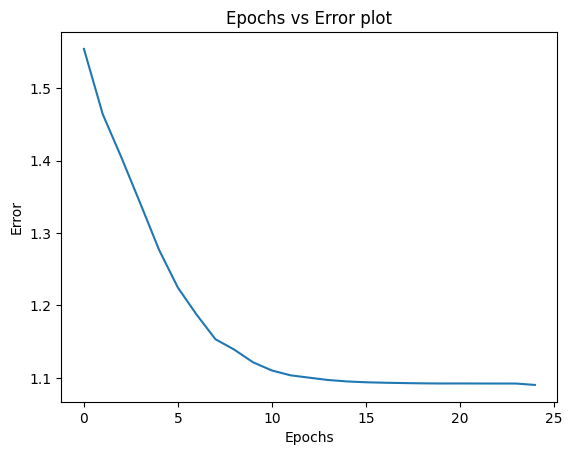

In [48]:
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Epochs vs Error plot')
plt.plot(err_plot)
plt.savefig('error_plot_iris.pdf')
plt.show()

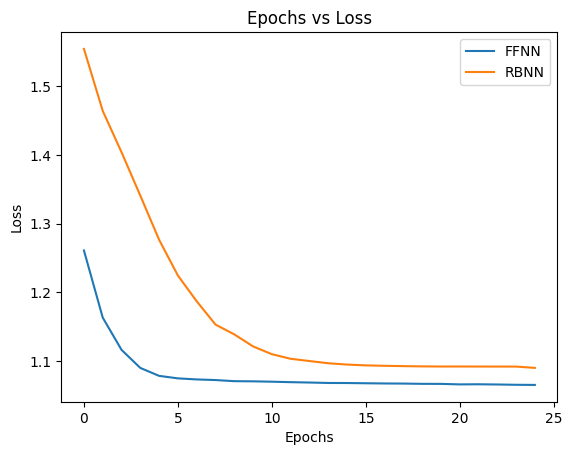

In [49]:
plt.plot(loss_list)
plt.plot(err_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend(['FFNN','RBNN'])
plt.savefig('loss_plot_pima.pdf')
plt.show()

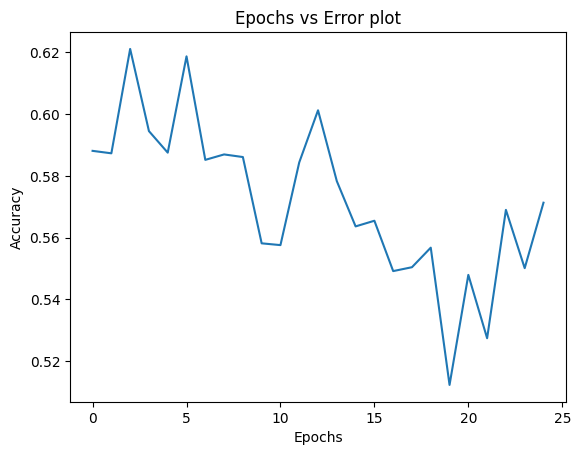

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Error plot')
plt.plot(np.array(acc_plot)/len(y))
plt.savefig('acc_plot_pima.pdf')
plt.show()

In [ ]:
loss_dictionary={'RBNN':err_plot}
df = pd.DataFrame(loss_dictionary)
df.to_excel('Loss_Restricted_BNN.xlsx')

In [28]:
#selected = np.random.randint(0,len(X),10)
for i in range(len(X)):
  print("Actual input:",X_new[i])
  model2.predict(X_new[i],y[i])

Actual input: [0.74371859 0.59016393 0.25909091]
Actual output:1 and predicted ouput:0
Actual input: [0.42713568 0.54098361 0.14504132]
Actual output:0 and predicted ouput:0
Actual input: [0.91959799 0.52459016 0.27768595]
Actual output:1 and predicted ouput:0
Actual input: [0.44723618 0.54098361 0.06900826]
Actual output:0 and predicted ouput:0
Actual input: [0.68844221 0.32786885 0.94545455]
Actual output:1 and predicted ouput:0
Actual input: [0.58291457 0.60655738 0.08305785]
Actual output:0 and predicted ouput:0
Actual input: [0.3919598  0.40983607 0.10247934]
Actual output:1 and predicted ouput:1
Actual input: [0.57788945 0.         0.0553719 ]
Actual output:0 and predicted ouput:0
Actual input: [0.98994975 0.57377049 0.06528926]
Actual output:1 and predicted ouput:0
Actual input: [0.6281407  0.78688525 0.09586777]
Actual output:1 and predicted ouput:0
Actual input: [0.55276382 0.75409836 0.07892562]
Actual output:0 and predicted ouput:0
Actual input: [0.84422111 0.60655738 0.2219

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [42]:
len(loss_list)

25

In [50]:
dict_for_error = {'RBNN':err_plot,'FFNN':loss_list}
df = pd.DataFrame(dict_for_error)
df.to_excel('Loss_Restricted_BNN.xlsx')